# Global Coronavirus Data Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import xkcd_rgb
import pygal
from IPython.display import display,HTML

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import os

In [2]:
dcate = ["confirmed","deaths","recovered"]

plt.style.use("seaborn-white")
plt.rcParams["font.sans-serif"] = "Arial"
def colors():
    cl = list()
    temp = pd.read_excel("Color.xlsx",header=0,index_col=0)
    temp /= 255
    for i in range(temp.shape[0]):
        cl.append(temp.iloc[i,:].to_list())
    return cl

def get_filename(middle):
    path_1 = "time_series_covid19_"
    path_2 = "_global.csv"
    name = path_1+middle+path_2
    return name

colorlist = colors()

# 1  Getting data by using a web crawler
The orginal datasets are all from the csv files uploaded on github by JHU.

Link: https://github.com/CSSEGISandData/COVID-19

The datasets include four components: global daily reports categorized by countries and regions, US daily reports, data provided by WHO.

First of all, a web crawler is needed to get the data from github. The crawler is based on Selenium, which is able to download the required data and export it to local.

#### Download the data and save as csv files

In [30]:
def update_data(dcate):
    for i in range(4):

        session = webdriver.Chrome()
        if i < 3:
            filename = get_filename(dcate[i])
            api = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"+filename
        else:
            filename = "who_covid_19_sit_rep_time_series.csv"
            api = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv"
        session.get(api)
        source = session.page_source
        session.quit()

        rmlist = re.compile('(<.*>)').findall(source)
        string = source
        for pat in rmlist:
            string = re.sub(pat,"",string)

        cwd = os.getcwd()
        files = os.listdir(cwd)
        if filename in files:
            os.remove(filename)
        else:
            pass
        with open(filename,"w",encoding="utf-8") as f:
            f.write(string)
            
update_data(dcate)

#### Read the csv files into a dictionary

In [3]:
def get_data(dcate):
    origindict = dict()
    for cate in dcate:
        temp = pd.read_csv(get_filename(cate),header=0,index_col=None)
        origindict[cate] = temp.groupby(by="Country/Region")[temp.columns[4:]] \
                               .sum().reset_index()
    countrylist = list(set(temp["Country/Region"]))
    
    filename = "who_covid_19_sit_rep_time_series.csv"
    temp = pd.read_csv(filename,skiprows=range(1,257),header=0,index_col=None)
    temp.dropna(axis=1,inplace=True)
    origindict["who"] = temp
    
    return origindict,countrylist

origindict,countrylist = get_data(dcate)

#### The list of the countries

In [9]:
countrylist.sort()
countrylist

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

# 2  Global confirmed and deaths cases by region

#### Global total confirmed and deaths

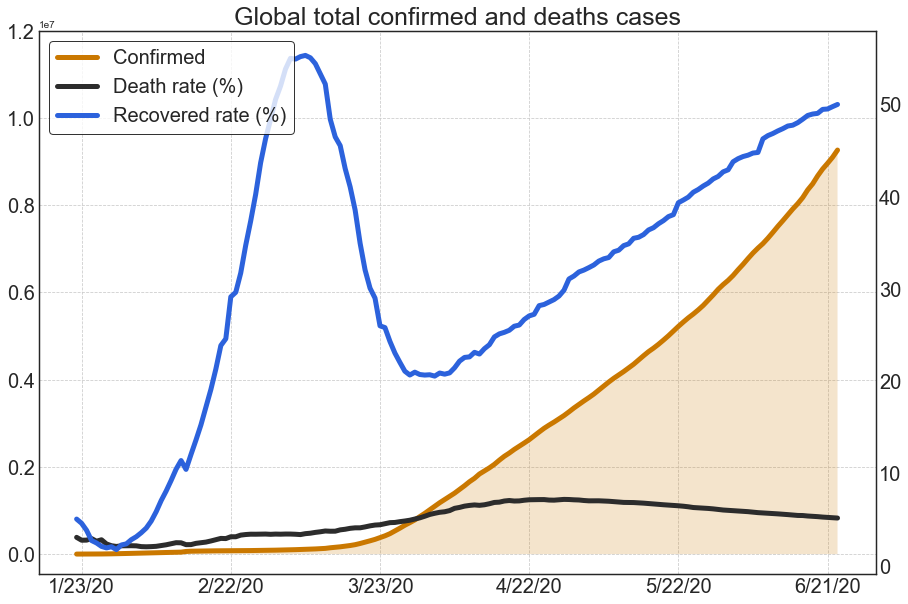

In [7]:
def plot_gtotal(dct,cl):
    temp = pd.DataFrame()
    temp["Confirmed"] = dct["confirmed"].sum().iloc[1:]
    temp["Death rate"] = dct["deaths"].sum().iloc[1:]/temp["Confirmed"]*100
    temp["Recovered rate"] = dct["recovered"].sum().iloc[1:]/temp["Confirmed"]*100
    temp = temp.T
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()
    lns = pd.DataFrame(index=range(3),columns=range(1))
    for i in range(3):
        lns.iloc[i,0] = ax.plot(temp.iloc[i,:],color=cl[i],linewidth=5)
        ax.tick_params(labelsize=20)
        if i == 0:
            ax.fill_between(range(temp.shape[1]),temp.iloc[i,:].to_list(),
                             facecolor=cl[i],alpha=0.2)
            ax.set_yticks(np.linspace(0,12000000,7))
            ax.grid(linestyle="--")
            ax = ax.twinx()
            
    ax.legend(lns.sum()[0],["Confirmed","Death rate (%)","Recovered rate (%)"],
              loc="upper left",fontsize=20,frameon=True,edgecolor="k")
    ax.set_xticks(range(1,temp.shape[1],30))
    ax.set_title("Global total confirmed and deaths cases",fontsize=25)
    plt.show()

plot_gtotal(origindict,colorlist)

#### The confirmed and deaths cases of the global different regions, as well as the death rate (death/confirmed)

In [60]:
def get_region(df):
    temp = pd.DataFrame(index=range(6),columns=range(3))
    temp.iloc[:,[0,1]] = df[df.iloc[:,0]=="Confirmed"].iloc[:,[1,-1]].values
    temp.iloc[:,[0,2]] = df[df.iloc[:,0]=="Deaths"].iloc[:,[1,-1]].values
    temp.sort_values(by=1,ascending=False,inplace=True)

    temp.columns = ["Region","Confirmed","Deaths"]
    temp = temp.set_index("Region")
    temp["D/C"] = temp["Deaths"]/temp["Confirmed"]
    
    return temp

region_data = get_region(origindict["who"])
print("Global Confirmed and Death Cases (by Region)")
print("%2s%30s%11s%10s%8s" % ("","Region","Confirmed","Deaths","D/C"))
for i in range(6):
    print("%2.0f%30s%11.0f%10.0f%7.2f%%" % (i+1,region_data.index[i],region_data.iloc[i,0],
                            region_data.iloc[i,1],region_data.iloc[i,2]*100))

Global Confirmed and Death Cases (by Region)
                          Region  Confirmed    Deaths     D/C
 1        Region of the Americas    2905432    163248   5.62%
 2               European Region    2175941    182416   8.38%
 3  Eastern Mediterranean Region     536148     12899   2.41%
 4        South-East Asia Region     283845      8000   2.82%
 5        Western Pacific Region     184305      7044   3.82%
 6                African Region     108121      2700   2.50%


#### Pie charts of the total confirmed and deaths cases

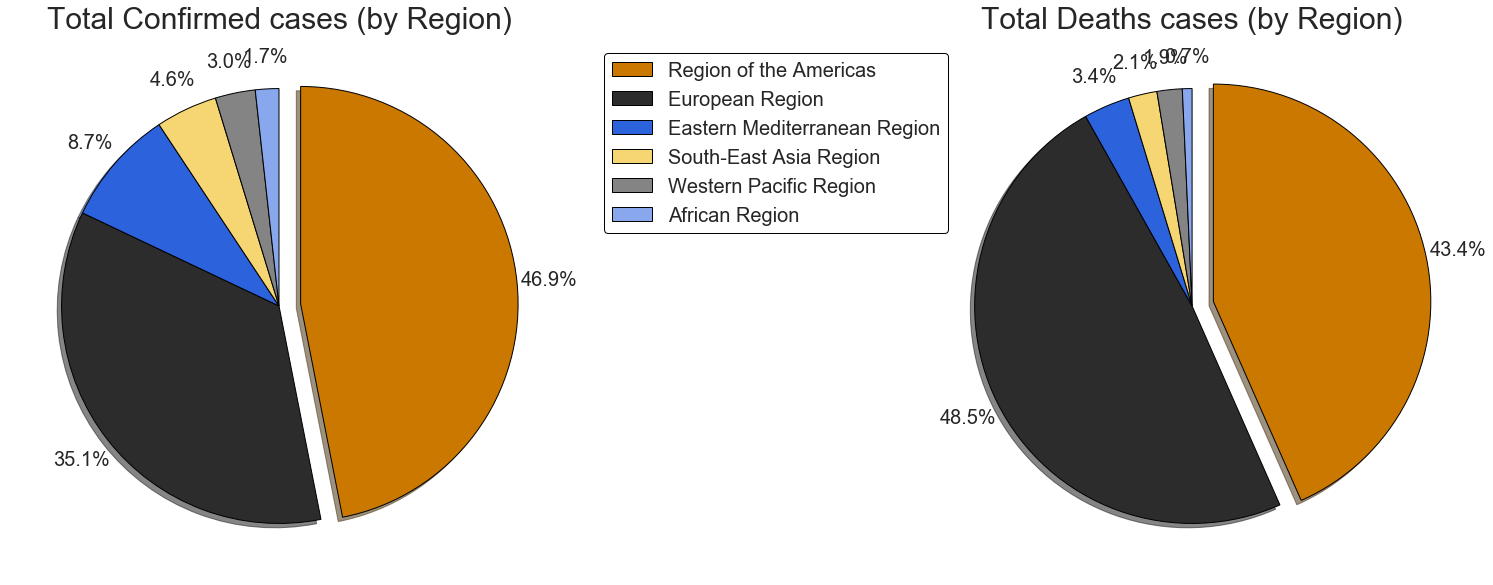

In [179]:
def plot_pie_region(df,cl):
    fig = plt.figure(figsize=(30,10))
    feature = ["Confirmed","Deaths"]
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1)
        ax.pie(df.iloc[:,i],colors=cl,explode=[0.1,0,0,0,0,0],
            autopct="%3.1f%%",pctdistance=1.15,
            startangle=90,counterclock=False,shadow=True,
            wedgeprops={"linewidth":1,"linestyle":"-","edgecolor":"k"},
            textprops={"fontsize":20})
        ax.set_title("Total "+feature[i]+" cases (by Region)",fontsize=30)
    
    ax.legend(df.index,loc=6,bbox_to_anchor=(-0.6,0.8),ncol=1,fontsize=20,
              frameon=True,framealpha=1,edgecolor="k")
    plt.show()
    
plot_pie_region(region_data,colorlist)

#### Time series of the confirmed cases and the deaths cases

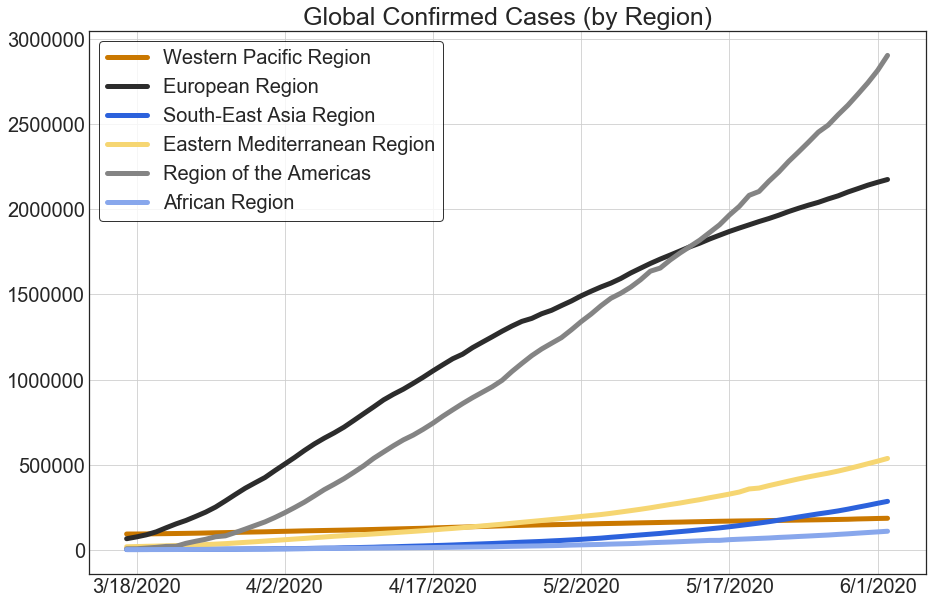

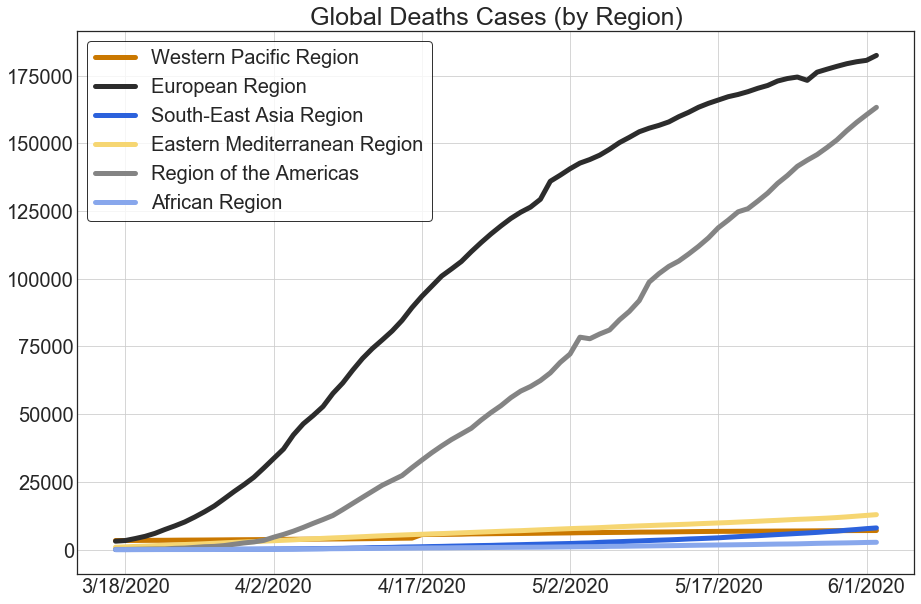

In [74]:
def plot_ts_region(df,cl):
    feature = ["Confirmed","Deaths"]
    for i in range(2):
        temp = df[df["Province/States"]==feature[i]].iloc[:,1:]
        ndays = temp.shape[1]-1
        
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot()
        for j in range(6):
            ax.plot(temp.iloc[j,1:],color=cl[j],linewidth=5)
        ax.tick_params(labelsize=20)
        ax.set_xticks(range(1,ndays,15))
        ax.legend(temp.iloc[:,0],loc="best",frameon=True,edgecolor="k",fontsize=20)
        ax.set_title("Global "+feature[i]+" Cases (by Region)",fontsize=25)
        ax.grid()
        plt.show()
plot_ts_region(origindict["who"],colorlist)

# 3  Active cases
Active = Confirmed - Deaths - Recovered

The number of active cases is able to denote the severity of the coronavirus state in a country directly. With the country's population, the density and severity of the virus can be examined.

The world map of the active cases is presented with pygal module. The names of the countries need to be transfered to the country code that pygal supports. From the github data source we could get a spreadsheet of the iso2 code of the countries, which can be used in the pygal module.

#### Transfer the country names into country codes

In [6]:
def country_code():
    df = pd.read_csv("UID_ISO_FIPS_LookUp_Table.csv",header=0,index_col=None)
    temp = df[["Country_Region","iso2"]].copy()
    temp.columns = ["Country/Region","code"]
    temp["code"] = temp["code"].str.lower()
    temp.drop_duplicates(subset="Country/Region",keep="first",inplace=True)
    return temp

def insert_cc(origindict):
    cc = country_code()
    for cat in origindict.keys():
        if "code" not in origindict[cat]:
            df = origindict[cat]
            col_value = pd.merge(df["Country/Region"],cc,on="Country/Region")
            origindict[cat].insert(1,"code",col_value["code"])
        else:
            pass
    
insert_cc(origindict)

#### The top 10 countries with the largest numbers of the active cases

In [7]:
def active_country(origindict,dcate):
    f = lambda i: origindict[dcate[i]]
    df = f(0).iloc[:,0:2].copy()
    df["Active"] = f(0).iloc[:,-1]-f(1).iloc[:,-1]-f(2).iloc[:,-1]
    
    df.dropna(subset=["code"],how="any",inplace=True)    
    
    return df

active = active_country(origindict,dcate)
active.sort_values(by="Active",ascending=False,inplace=True)
print("Global Active (Top 10 Countries)")
for i in range(10):
    print("%-20s%7.0f" % (active["Country/Region"].iloc[i],active["Active"].iloc[i]))

Global Active (Top 10 Countries)
US                  1578246
Brazil               465298
United Kingdom       263341
Russia               234682
India                183022
Pakistan             107417
Peru                 103969
France                93086
Bangladesh            70018
Spain                 68051


#### Log active cases (x-axis denotes the countries)

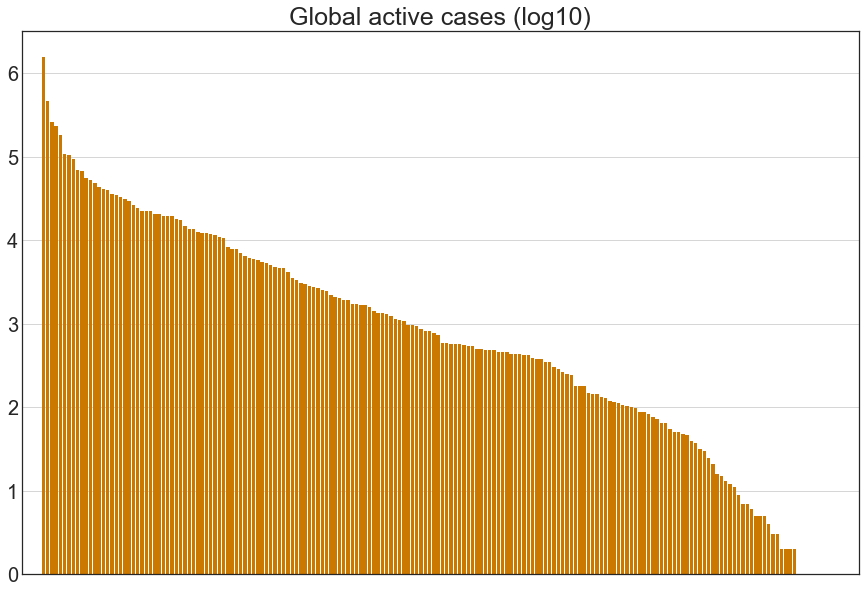

In [8]:
def plot_log(act,cl):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()
    ax.bar(act["Country/Region"],np.log10(act["Active"]+1),color=cl[0])
    ax.tick_params(labelsize=20)
    ax.set_xlim([-5,190])
    ax.set_xticklabels(labels=[])
    ax.set_title("Global active cases (log10)",fontsize=25)
    plt.grid(axis="y")
    plt.show()
    
plot_log(active,colorlist)

In [9]:
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

#### World map of the active cases by country

In [10]:
def plot_map(origindict,dcate):
    df = active_country(origindict,dcate)

    oc = pygal.maps.world.COUNTRIES
    rm = list(set(df["code"])-set(oc))
    oc= list(set(oc) & set(df["code"]))
    for c in rm:
        idx = df[df["code"]==c].index
        df.drop(idx,inplace=True)
    df = df.set_index("code")

    custom_style = pygal.style.Style(colors=("#88A7EC","#F6D672","#CA3434","#CA3434"),
                                     plot_background="#F1F1F1",background="#FFFFFF",
                                     title_font_family="Arial",title_font_size=25,
                                     label_font_family="Arial",label_font_size=14,
                                     legend_font_family="Arial",legend_font_size=14)

    map_chart = pygal.maps.world.World(legend_at_bottom=True,
                                       legend_at_bottom_columns=3,style=custom_style)
    map_chart.title = "Global Active Cases, by Country"
    nodes = [0,10000,80000]

    for i in range(len(nodes)):
        if i == 0:
            tdct = df[df["Active"]<nodes[i+1]]["Active"].to_dict()
            map_chart.add(str(nodes[i])+" - "+str(nodes[i+1]),tdct)
        elif i == len(nodes)-1:
            tdct = df[df["Active"]>=nodes[i]]["Active"].to_dict()
            map_chart.add(str(nodes[i])+" - ",tdct)
        else:
            tdct = df[(df["Active"]>=nodes[i])&(df["Active"]<nodes[i+1])]["Active"].to_dict()
            map_chart.add(str(nodes[i])+" - "+str(nodes[i+1]),tdct)

    galplot(map_chart)
    
plot_map(origindict,dcate)

# 4  Confirmed, deaths and recovered cases by country

#### Get the cases data of countries and calculate the basic ratios

In [21]:
def get_country(origindict,dcate):
    c_dict = dict()
    countrylist = list(set(origindict[dcate[0]]["Country/Region"]))
    for ctr in countrylist:
        tmp = pd.DataFrame(columns=dcate+["new_c","new_d","new_r","ratio_d/c","ratio_r/c",
                                           "ratio_a/c"])
        for i in range(3):
            cond = origindict[dcate[i]]["Country/Region"]==ctr
            tmp.iloc[:,i] = origindict[dcate[i]][cond].iloc[0,2:]
            tmp.iloc[:,3+i] = tmp[dcate[i]].diff().fillna(0)
        tmp["ratio_d/c"] = tmp.iloc[:,1]/tmp.iloc[:,0]
        tmp["ratio_r/c"] = tmp.iloc[:,2]/tmp.iloc[:,0]
        tmp["ratio_a/c"] = 1-tmp["ratio_d/c"]-tmp["ratio_r/c"]
        tmp.iloc[:,6:9] = tmp.iloc[:,6:9].fillna(0)
        c_dict[ctr] = tmp
        
    return c_dict

c_dict = get_country(origindict,dcate)

#### top 10 countries on the death rate (deaths/confirmed)

In [58]:
def print_ratio(c_dict):
    temp = pd.DataFrame(index=countrylist,columns=["confirmed","ratio_d/c"])
    for ctr in countrylist:
        temp.loc[ctr,"confirmed"] = c_dict[ctr].iloc[-1,0]
        temp.loc[ctr,"ratio_d/c"] = c_dict[ctr].iloc[-1,6]
    temp = temp[temp["confirmed"]>=100]
    temp.sort_values(by="ratio_d/c",ascending=False,inplace=True)
    print("Death ratio: deaths/confirmed (top 10 countries)")
    print("%2s%17s%12s%12s" % ("","Country","Confirmed","Ratio_d/c"))
    for i in range(10):
        print("%2s%17s%12.0f%11.2f%%" % (i+1,temp.index[i],temp.iloc[i,0],temp.iloc[i,1]*100))

print_ratio(c_dict)

Death ratio: deaths/confirmed (top 10 countries)
            Country   Confirmed   Ratio_d/c
 1            Yemen         992      26.31%
 2          Belgium       60810      15.97%
 3           France      197804      15.03%
 4            Italy      238833      14.52%
 5   United Kingdom      307682      13.98%
 6          Hungary        4107      13.95%
 7      Netherlands       49930      12.25%
 8           Mexico      191410      12.21%
 9            Spain      246752      11.48%
10          Bahamas         104      10.58%


## 4.1  Time series of the confirmed, deaths and recovered cases of some countries

In [34]:
def present_data(df0,ctr):
    df = pd.DataFrame(index=["Total Active","Total Confirmed","Total Deaths",
                                  "Total Recovered","New Confirmed","New Deaths",
                                  "New Recovered","Deaths/Confirmed","Recovered/Confirmed",
                                  "Active/Confirmed"],columns=[ctr])
    df.iloc[0,0] = df0.iloc[-1,-1]*df0.iloc[-1,0]
    for i in range(9):
        df.iloc[i+1,0] = df0.iloc[-1,i]
    
    return df

def plot_num(df,ctr):
    fig = plt.figure(figsize=(30,20))
    num_tick = range(0,df.shape[0],30)
    for i in range(6):
        ax = fig.add_subplot(2,3,i+1)
        try:
            ax.plot(df.iloc[:,i],linewidth=4,color=colorlist[i])
            if i == 0:
                temp = df["confirmed"]-df["deaths"]-df["recovered"]
                ax.plot(temp,linewidth=4,color=colorlist[i+3])
            elif (i>=3) & (i<=5):
                ax.plot(df.iloc[:,i],linewidth=4,color=colorlist[i-3])
        except:
                ax.plot(df.iloc[:,i],linewidth=4,color=colorlist[i-3])
        ax.set_xticks(num_tick)
        ax.set_xticklabels(df.index[num_tick])
        ax.tick_params(labelsize=14)
        ax.set_xlim(0,df.shape[0])
        ax.set_xlabel("Date",fontsize=14)
        ax.set_title(df.columns[i],fontsize=28)
        plt.grid()
    fig.suptitle("CDR numbers of "+ctr,fontsize=42)
    plt.show()
    
def plot_rate(df,ctr):
    fig = plt.figure(figsize=(10,10))
    num_tick = range(0,df.shape[0],30)
    ax = fig.add_subplot(1,1,1)
    for i in range(3):
        ax.plot(df.iloc[:,i+6],linewidth=4,color=colorlist[i])
        ax.set_xticks(num_tick)
        ax.set_xticklabels(df.index[num_tick],rotation=45)
        ax.tick_params(labelsize=14)
        ax.set_xlim(0,df.shape[0])
        ax.set_ylim(0,1)
        ax.set_xlabel("Date",fontsize=14)
        if i == 2:
            ax.fill_between(df.index,df.iloc[:,i+6],interpolate=True,
                            facecolor=colorlist[i],alpha=0.1)
    ax.legend(df.columns[6:9],loc="upper center",bbox_to_anchor=(0.5,1.1),ncol=3,
              fontsize=14,frameon=True,edgecolor="k")
    ax.set_title("CDR ratios of "+ctr,pad=70,fontsize=28)
    plt.grid()
    plt.show()

In [35]:
ctrlist = ["China","US","United Kingdom","Brazil","India","Russia"]
for i in range(len(ctrlist)):
    present = present_data(c_dict[ctrlist[i]],ctrlist[i])
    print("Country:",ctrlist[i])
    for i in range(present.shape[0]):
        if i < 7:
            print("%-20s%8.0f" % (present.index[i],present.iloc[i,0]),sep="")
        else:
            print("%-20s%7.2f%%" % (present.index[i],present.iloc[i,0]*100),sep="")
    print()

Country: China
Total Active             458
Total Confirmed        84653
Total Deaths            4640
Total Recovered        79555
New Confirmed             29
New Deaths                 1
New Recovered              8
Deaths/Confirmed       5.48%
Recovered/Confirmed   93.98%
Active/Confirmed       0.54%

Country: US
Total Active         1578246
Total Confirmed      2347022
Total Deaths          121228
Total Recovered       647548
New Confirmed          34720
New Deaths               826
New Recovered           7350
Deaths/Confirmed       5.17%
Recovered/Confirmed   27.59%
Active/Confirmed      67.24%

Country: United Kingdom
Total Active          263341
Total Confirmed       307682
Total Deaths           43011
Total Recovered         1330
New Confirmed            921
New Deaths               280
New Recovered              8
Deaths/Confirmed      13.98%
Recovered/Confirmed    0.43%
Active/Confirmed      85.59%

Country: Brazil
Total Active          465298
Total Confirmed      1145906
To

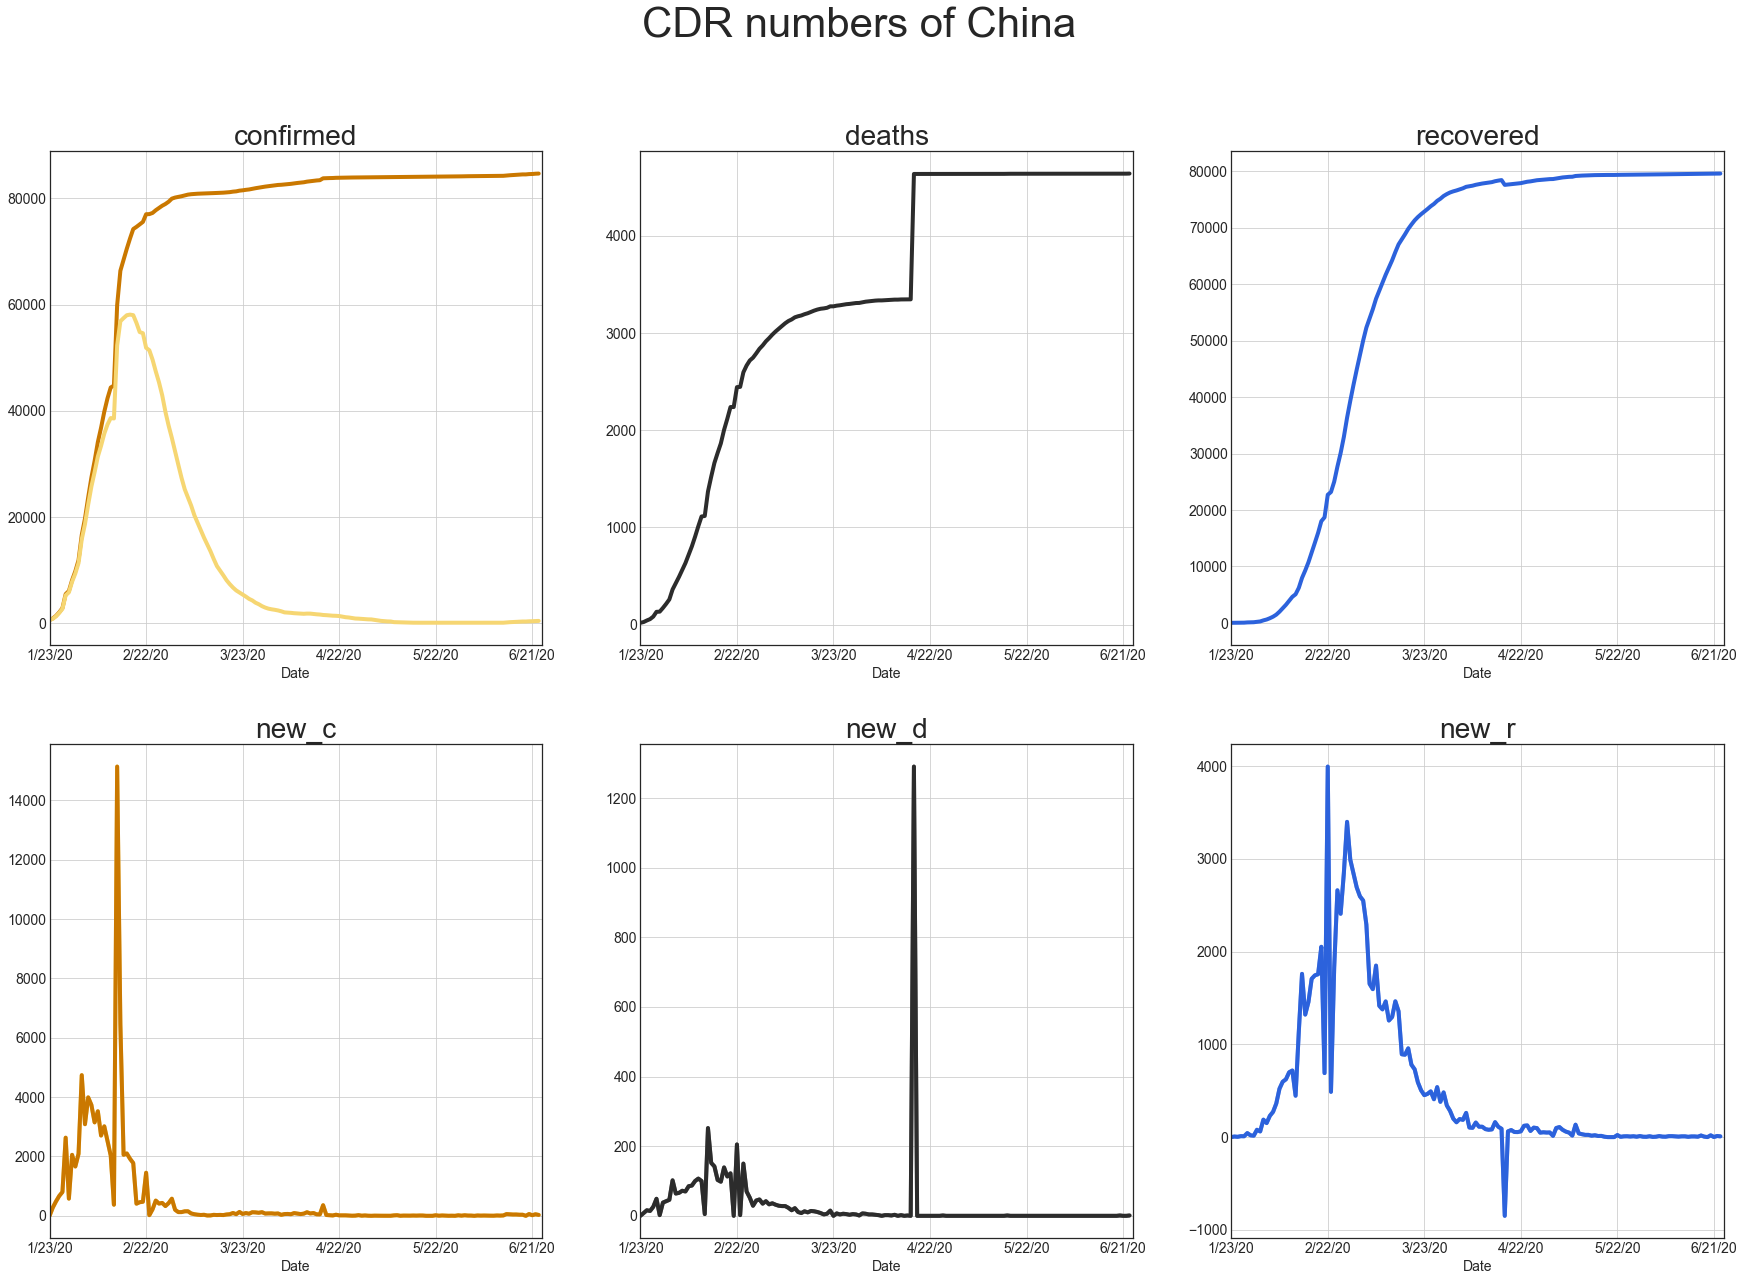

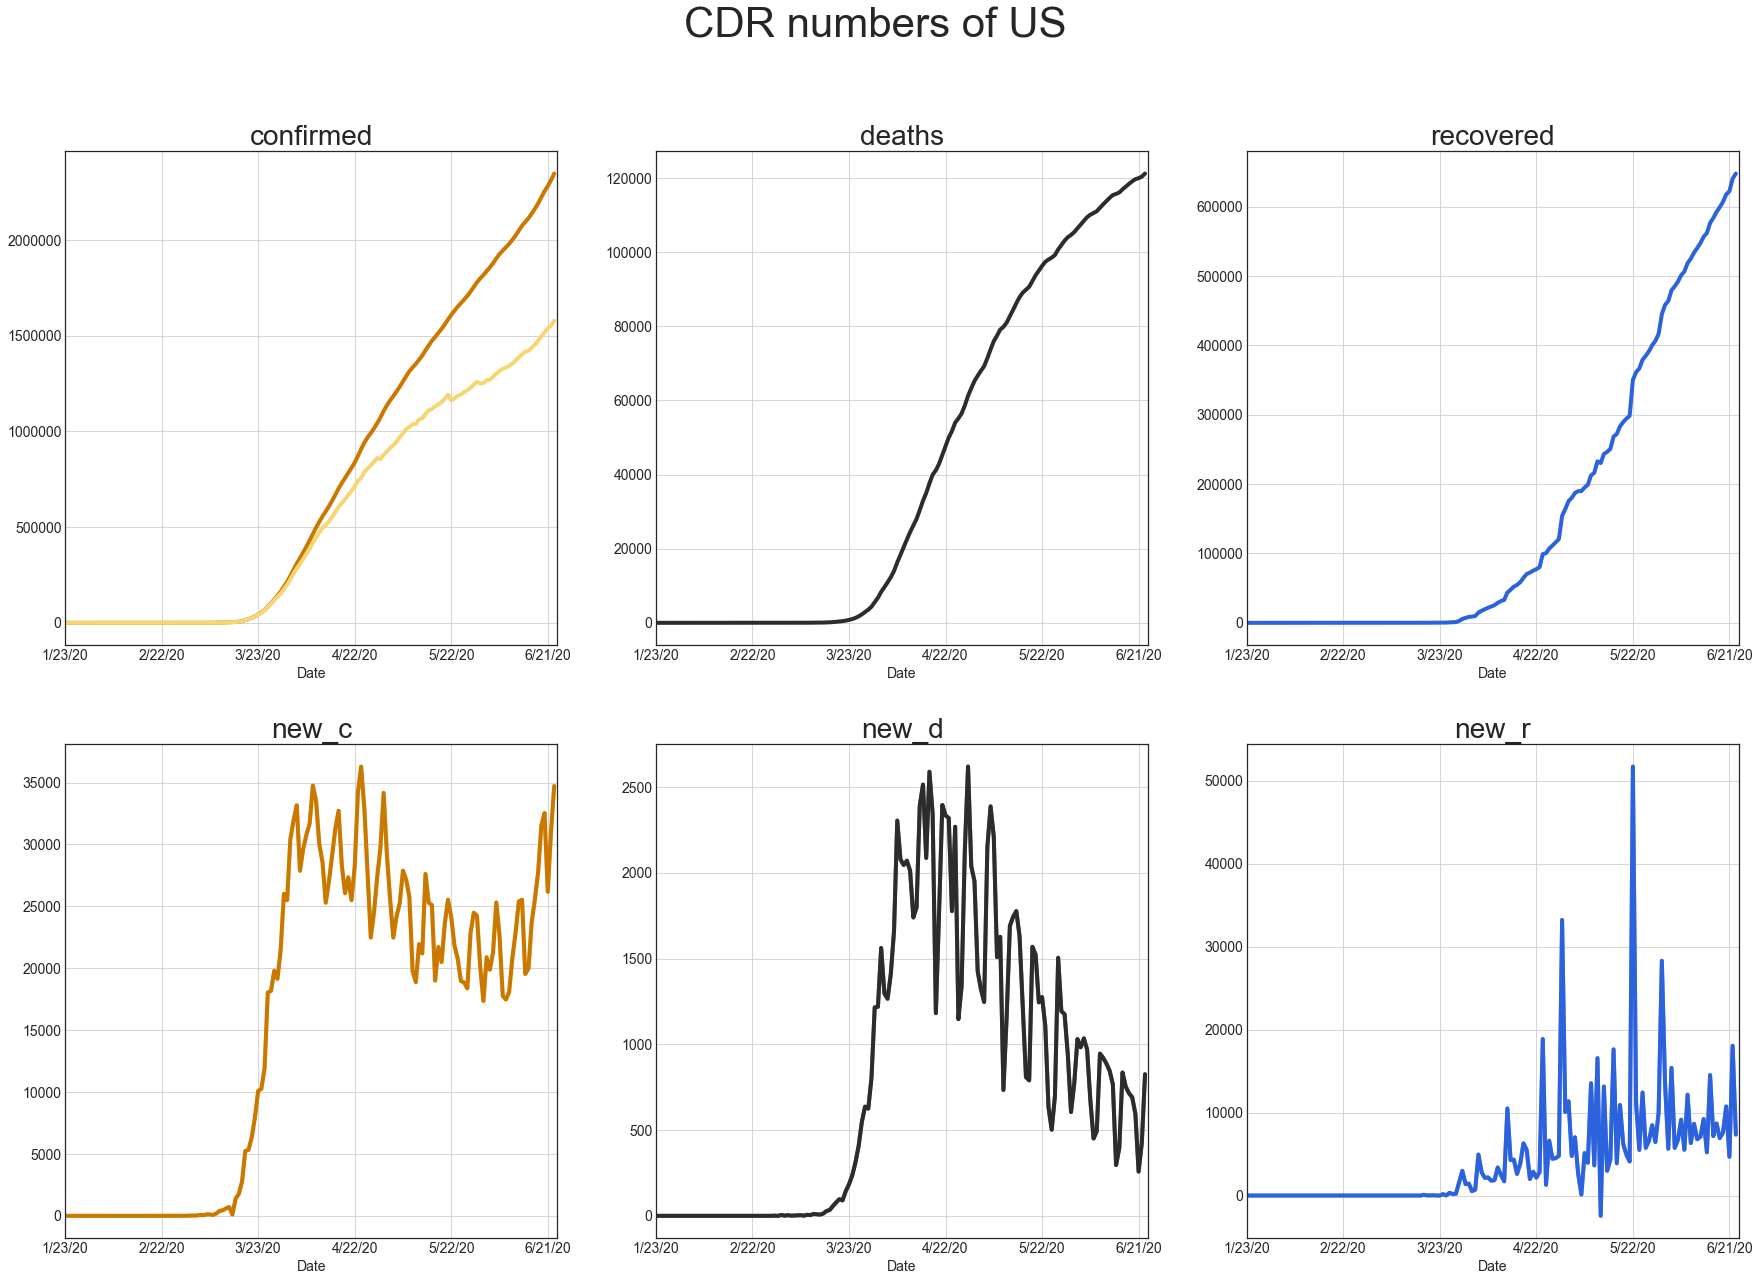

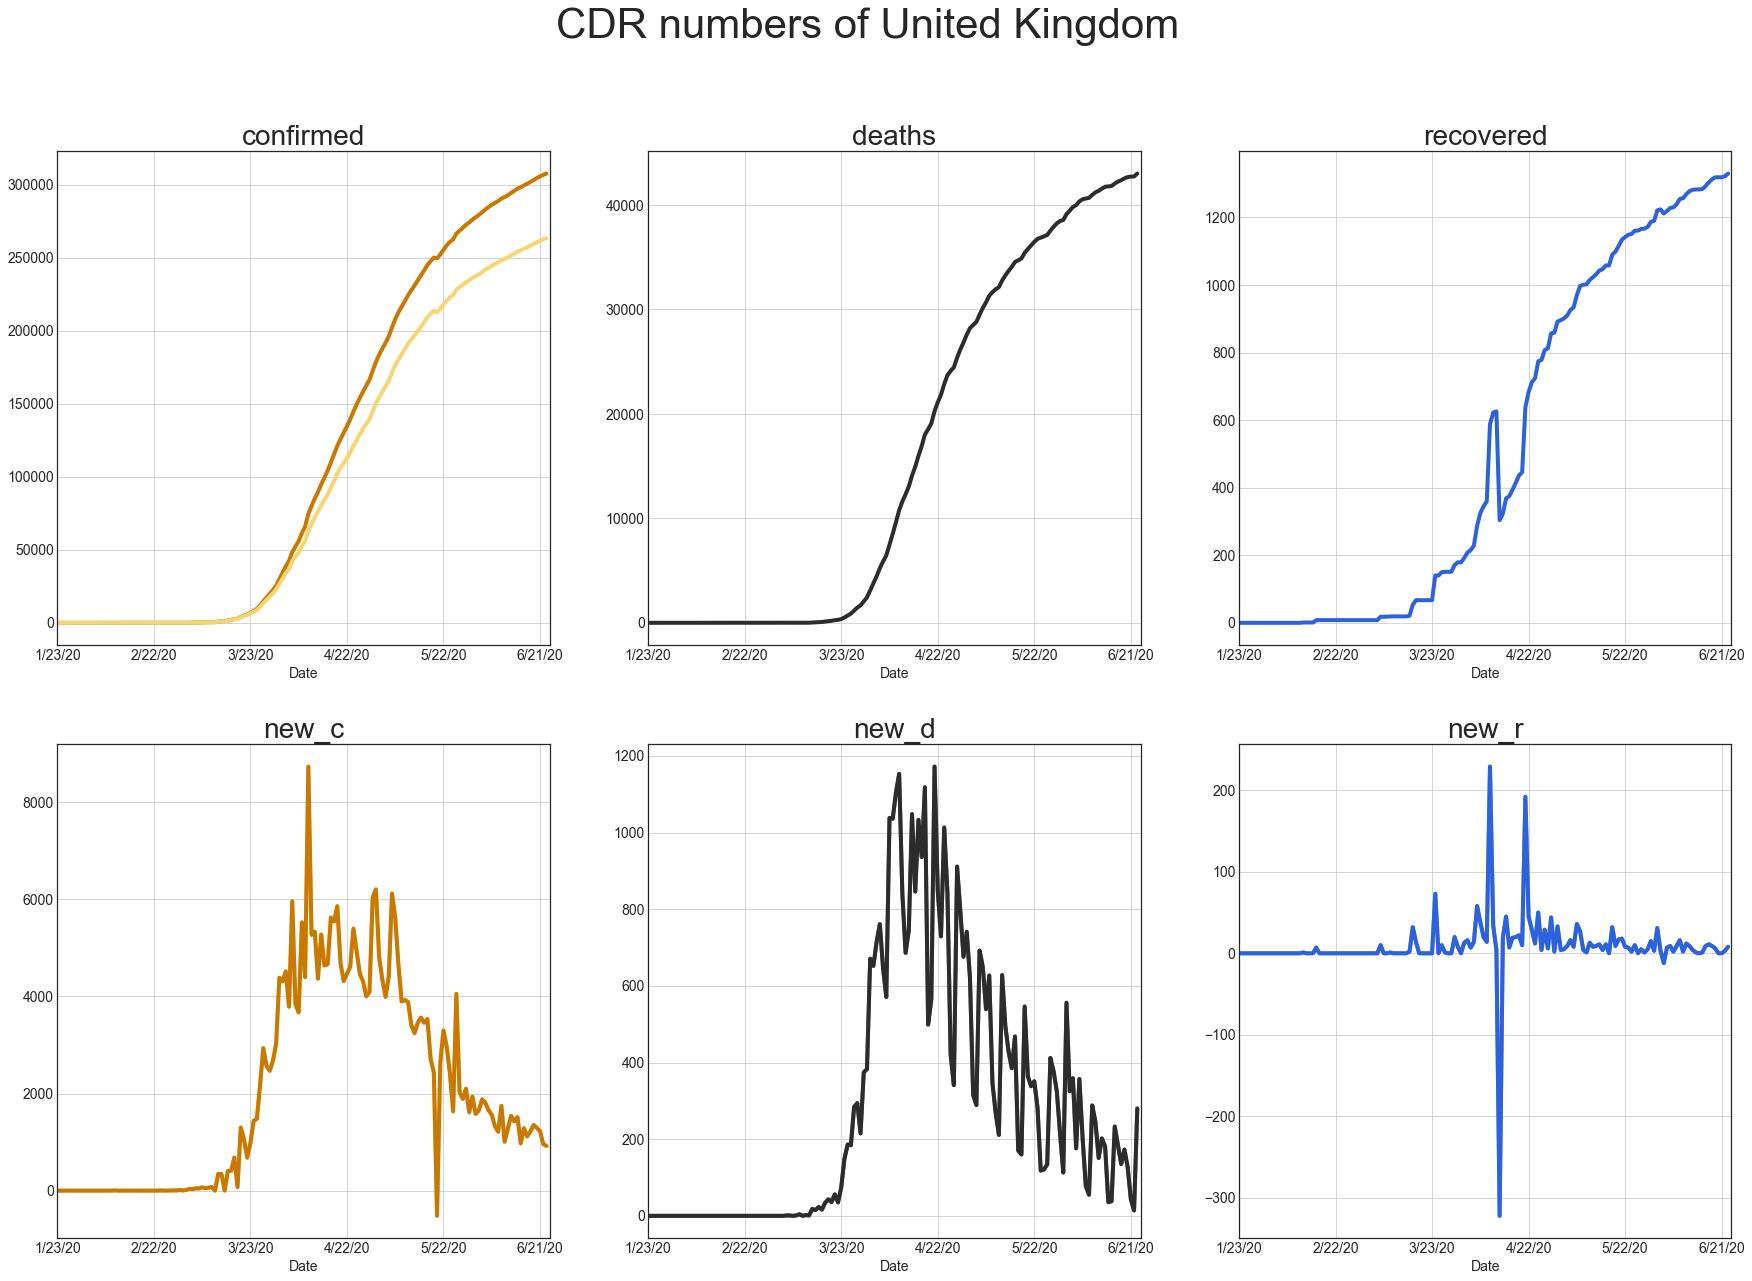

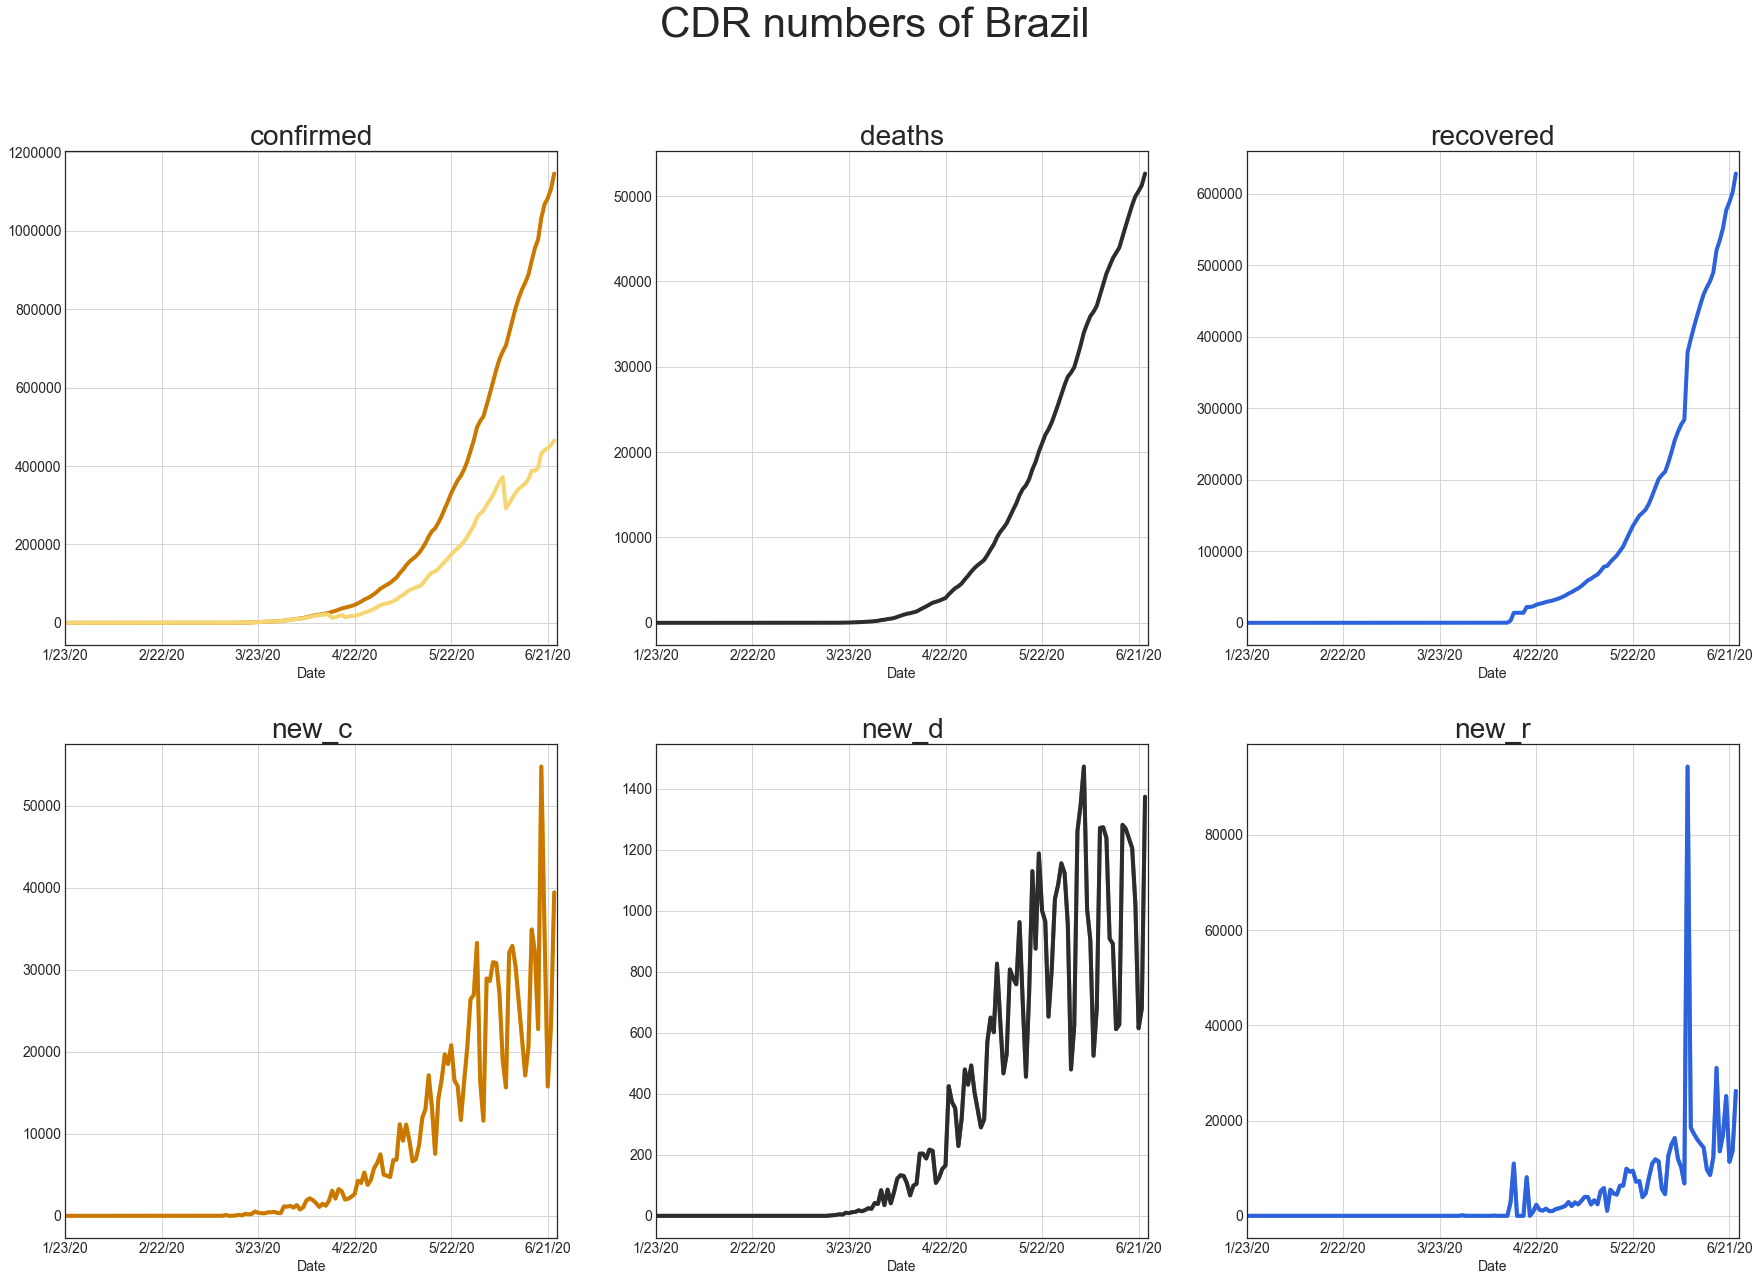

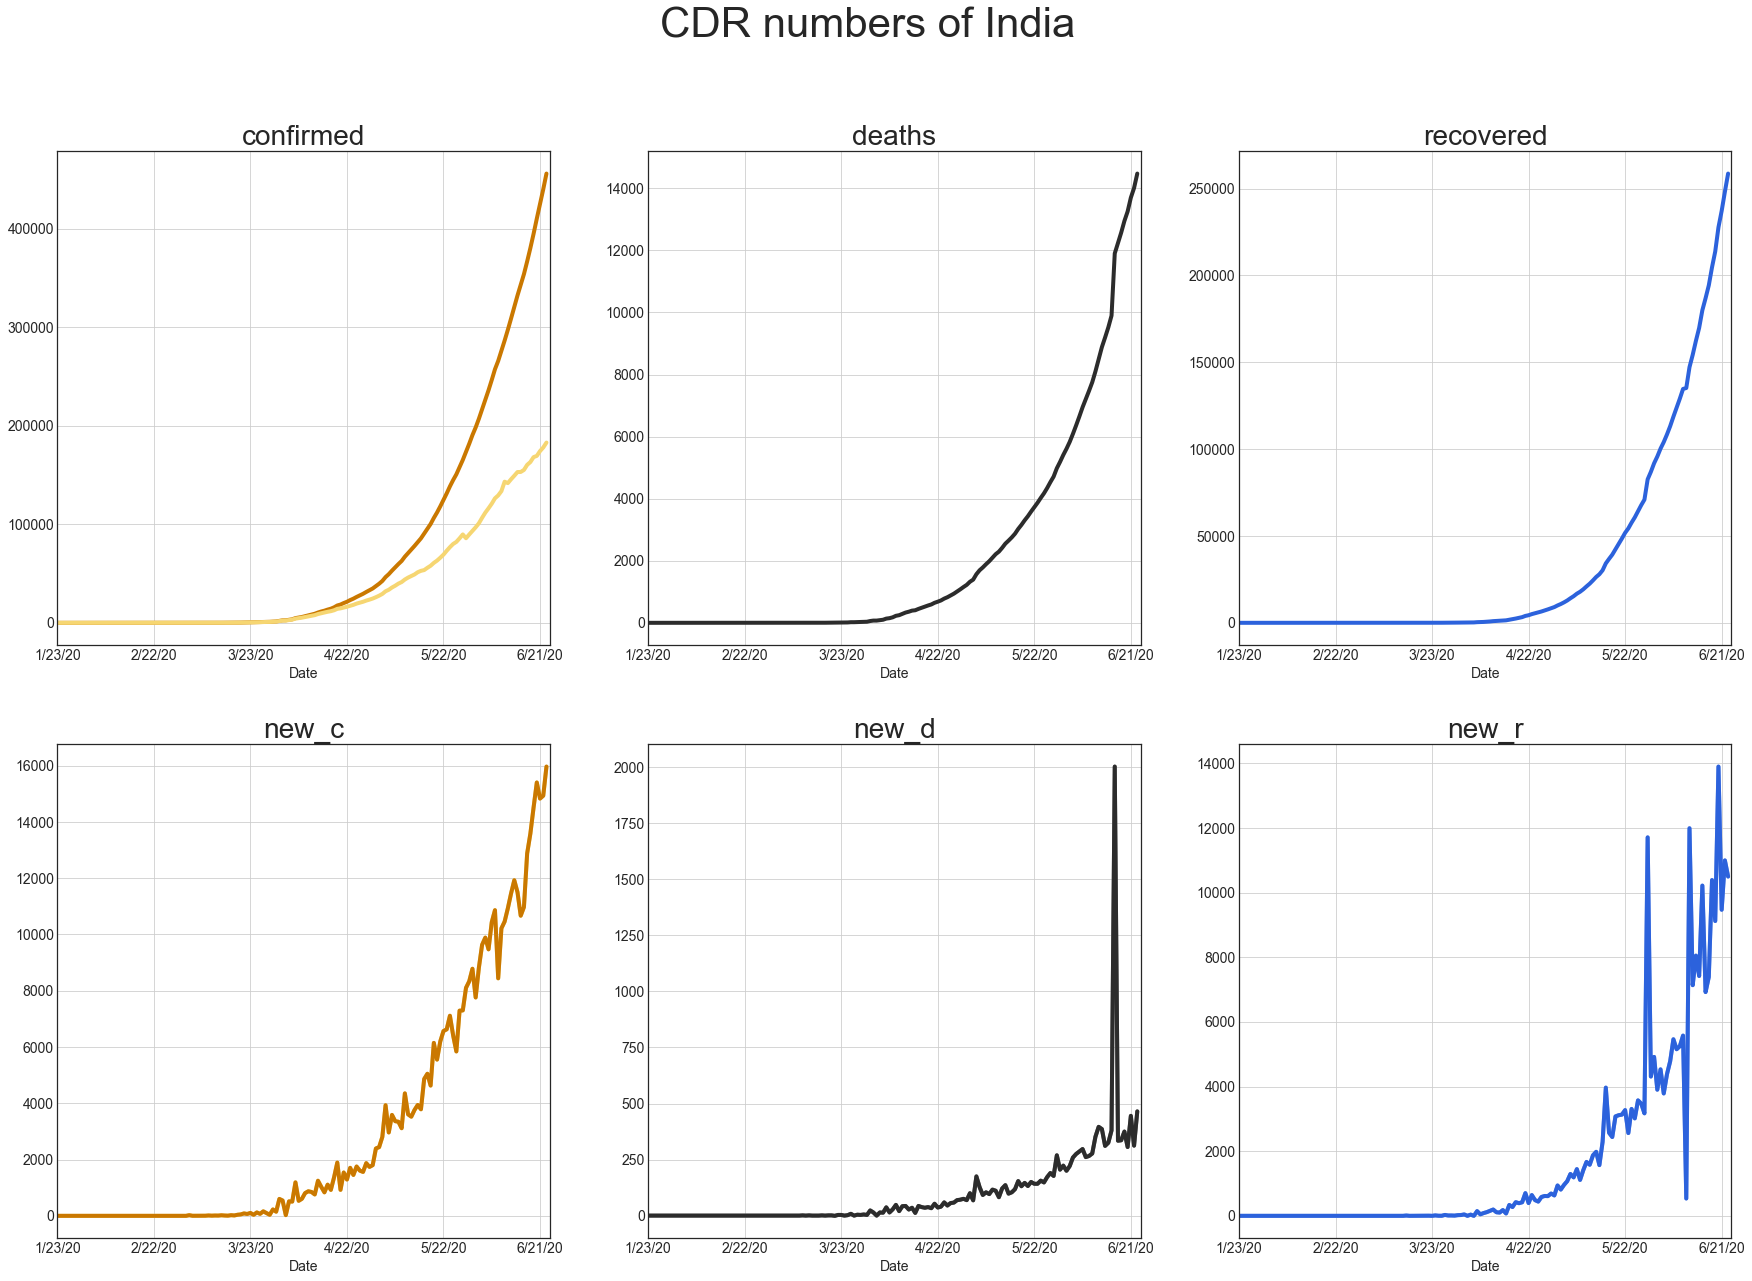

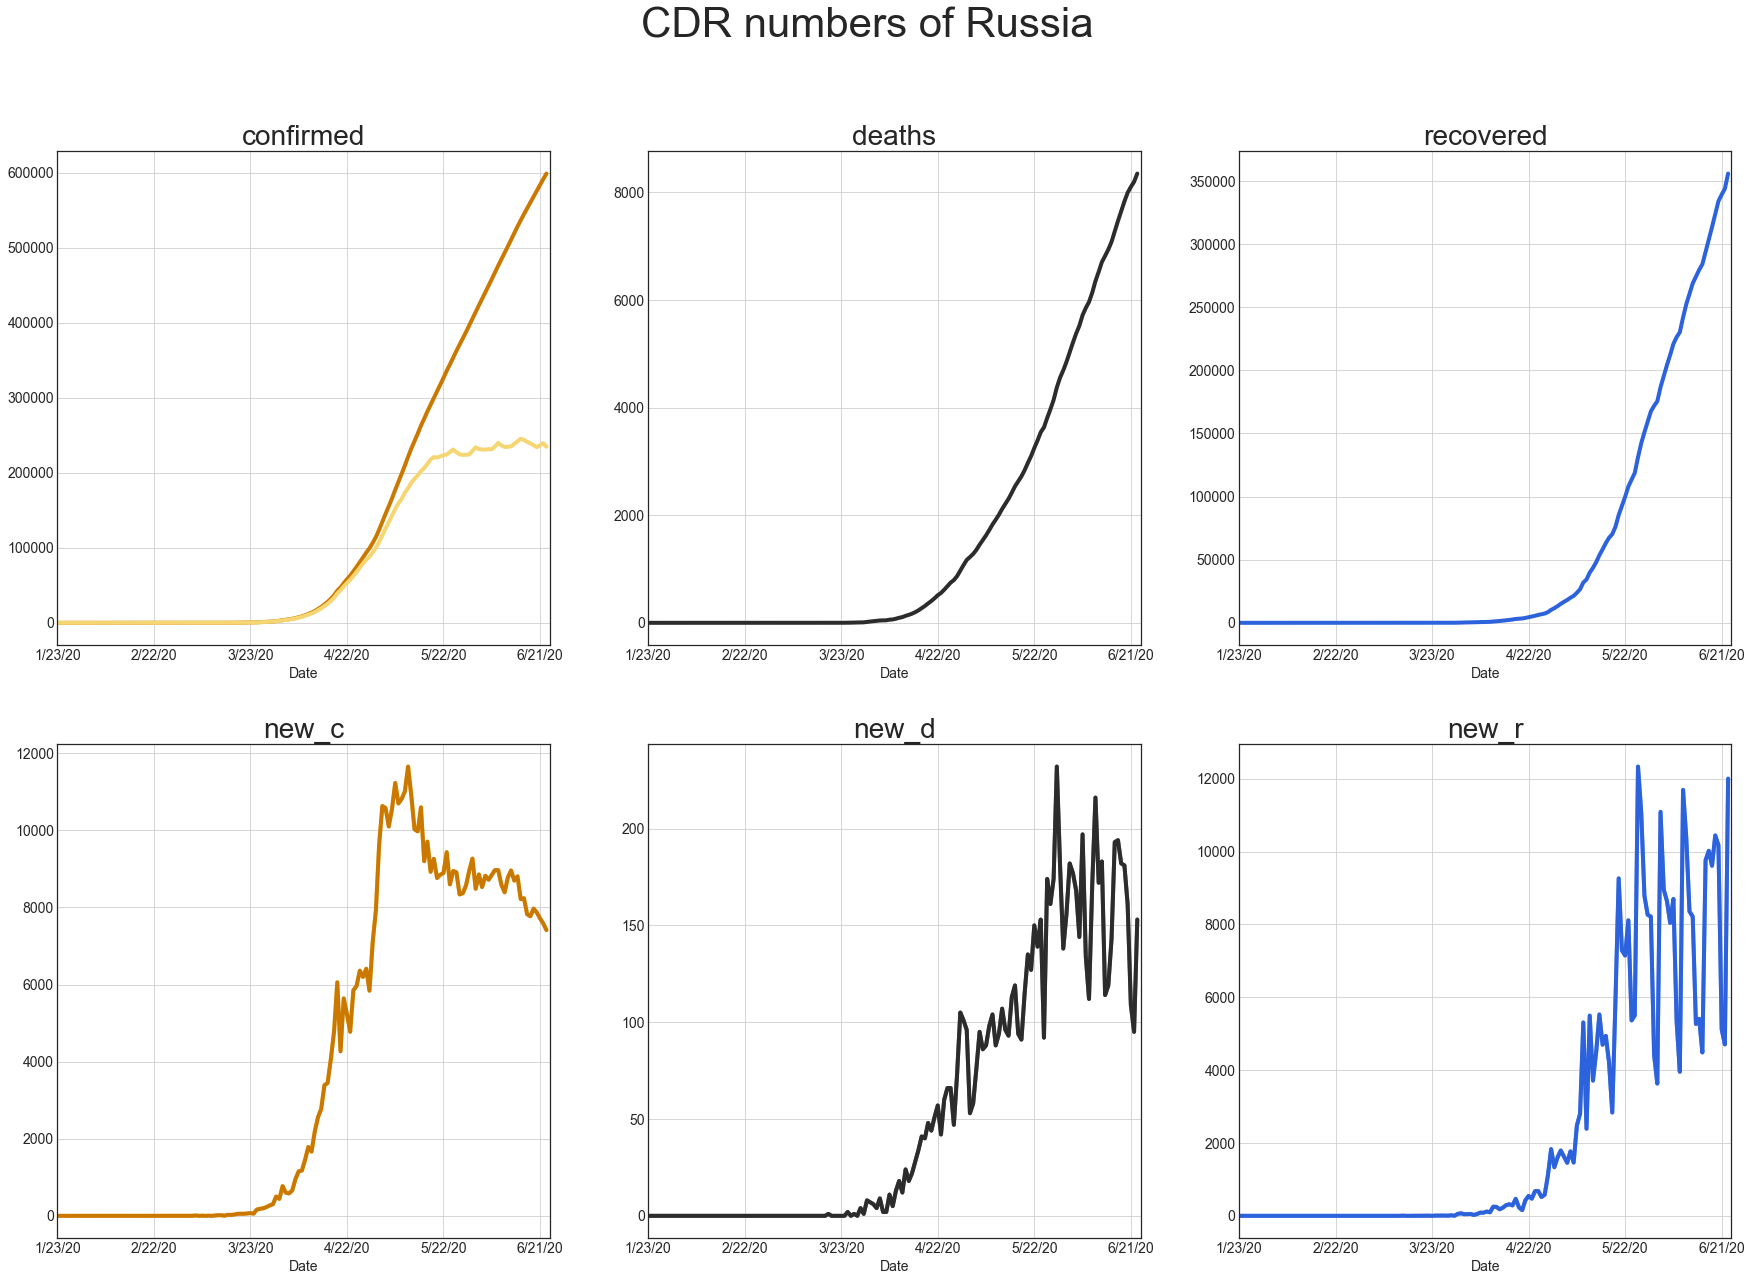

In [28]:
for i in range(len(ctrlist)):
    plot_num(c_dict[ctrlist[i]],ctrlist[i])

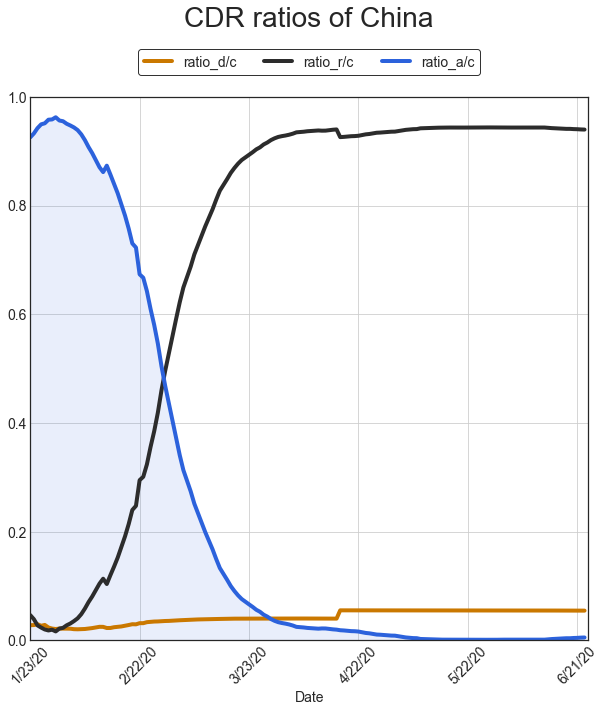

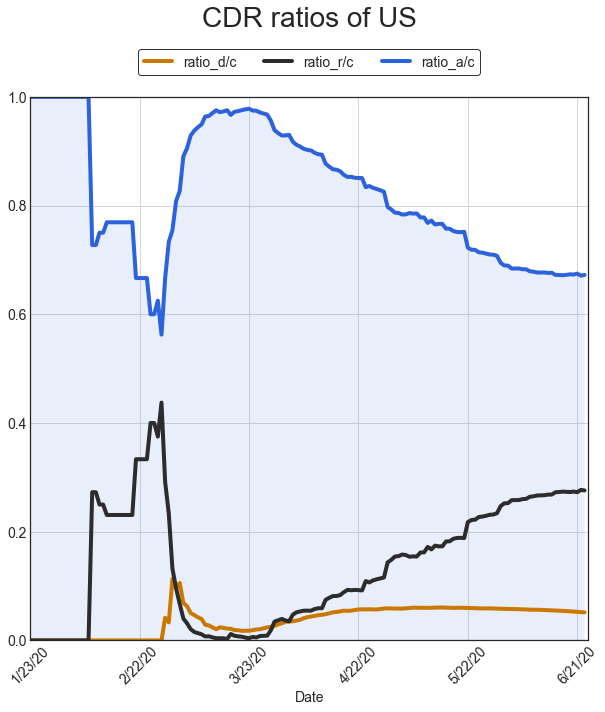

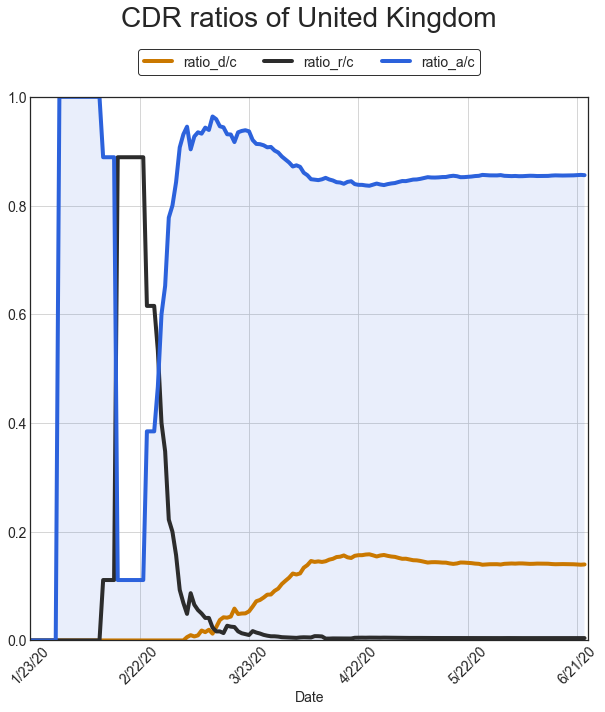

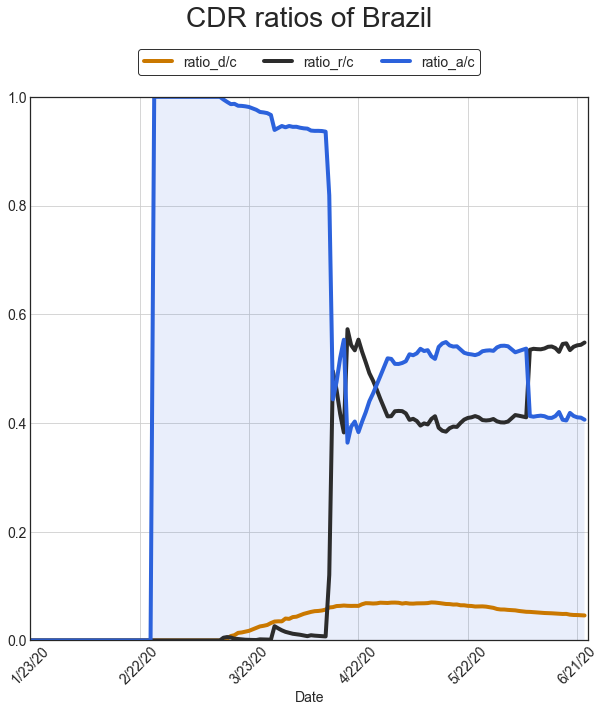

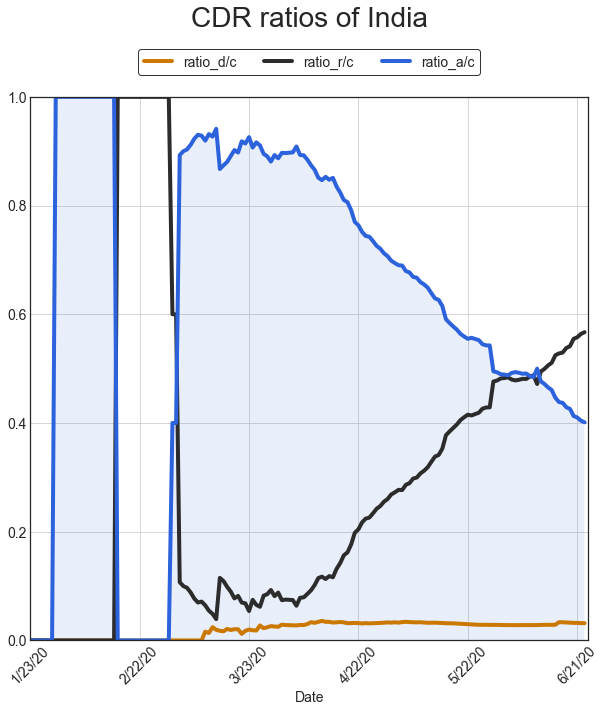

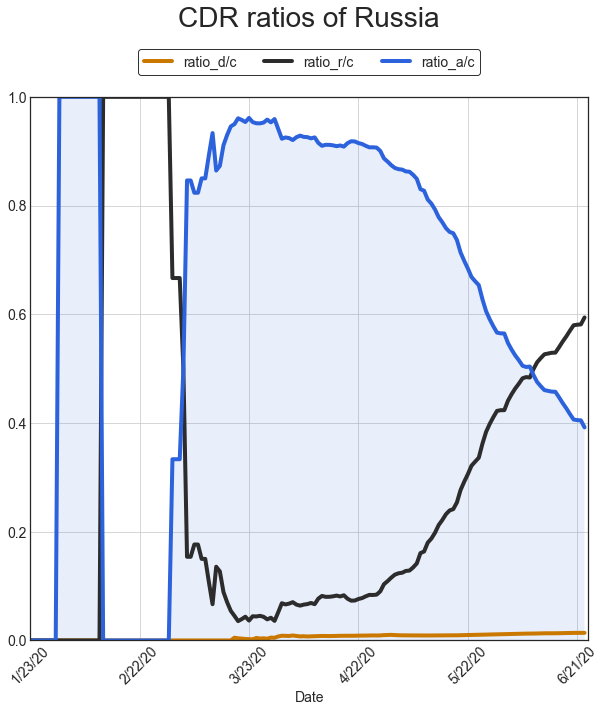

In [29]:
for i in range(len(ctrlist)):
    plot_rate(c_dict[ctrlist[i]],ctrlist[i])

## 4.2  The Abnormal Changes in recent days
Observe the ratio of newly confirmed cases and active cases, and calculate its mean and standard deviation. Sort the countries based on the deviate level from the mean. Mark all the countries of which the ratio of the newest day receives an abnormal change.

In two circumstances, this methods could be ineffective: 1. the total confirmed cases of the country is few; 2. The statistical range of the country has changed.

This index is only for short term, which is effective for finding the countries of which the virus state has changed during last several days.

In [15]:
def new_chg(c_dict):
    tsidx = c_dict["China"].iloc[-21:].index.to_list()
    ratio_ts = pd.DataFrame(index=c_dict.keys(),
                         columns=["r","active"]+tsidx)
    eps = 10**(-3)
    for ctr in c_dict.keys():
        newactive = c_dict[ctr].iloc[-1,0]-c_dict[ctr].iloc[-1,1]-c_dict[ctr].iloc[-1,2]
        temp = c_dict[ctr]["new_c"].diff().iloc[-21:]/(newactive+eps)
        ratio_ts.loc[ctr,"active"] = newactive
        ratio_ts.loc[ctr,"r"] = (temp.iloc[-1]-temp.iloc[-21:-1].mean()) \
                           /(temp.iloc[-21:-1].std()+eps)
        ratio_ts.loc[ctr,tsidx] = temp.copy()
        
    return ratio_ts

ratio_ts = new_chg(c_dict)
ratio_ts.sort_values(by="r",ascending=False,inplace=True)
print("Abnormal changes in confirmed cases (>2.0)")
print("%2s%24s%12s%12s%12s" % ("","Country","miu","active","chgrate"))
i = 0
while ratio_ts.iloc[i,0]>2:
    print("%-2s%24s%12.2f%12.0f%12.2f" % \
          (i+1,ratio_ts.index[i],ratio_ts.iloc[i,0],ratio_ts.iloc[i,1],
           ratio_ts.iloc[i,-1]))
    i += 1
ab_num = i

Abnormal changes in confirmed cases (>2.0)
                   Country         miu      active     chgrate
1            Liechtenstein        8.28          12        0.17
2                 Slovenia        4.26          49        0.24
3                  Belgium        3.87       34326        0.01
4                  Croatia        3.64         117        0.09
5               Kyrgyzstan        3.29        1602        0.23
6                  Czechia        2.94        2756        0.04
7                   Sweden        2.75       55676        0.03
8                Sri Lanka        2.66         432        0.09
9               Luxembourg        2.20          64        0.17
10                  Uganda        2.19          98        0.19
11                  Mexico        2.17       24387        0.07
12             Philippines        2.03       22197        0.02
13               Nicaragua        2.01         858        0.40


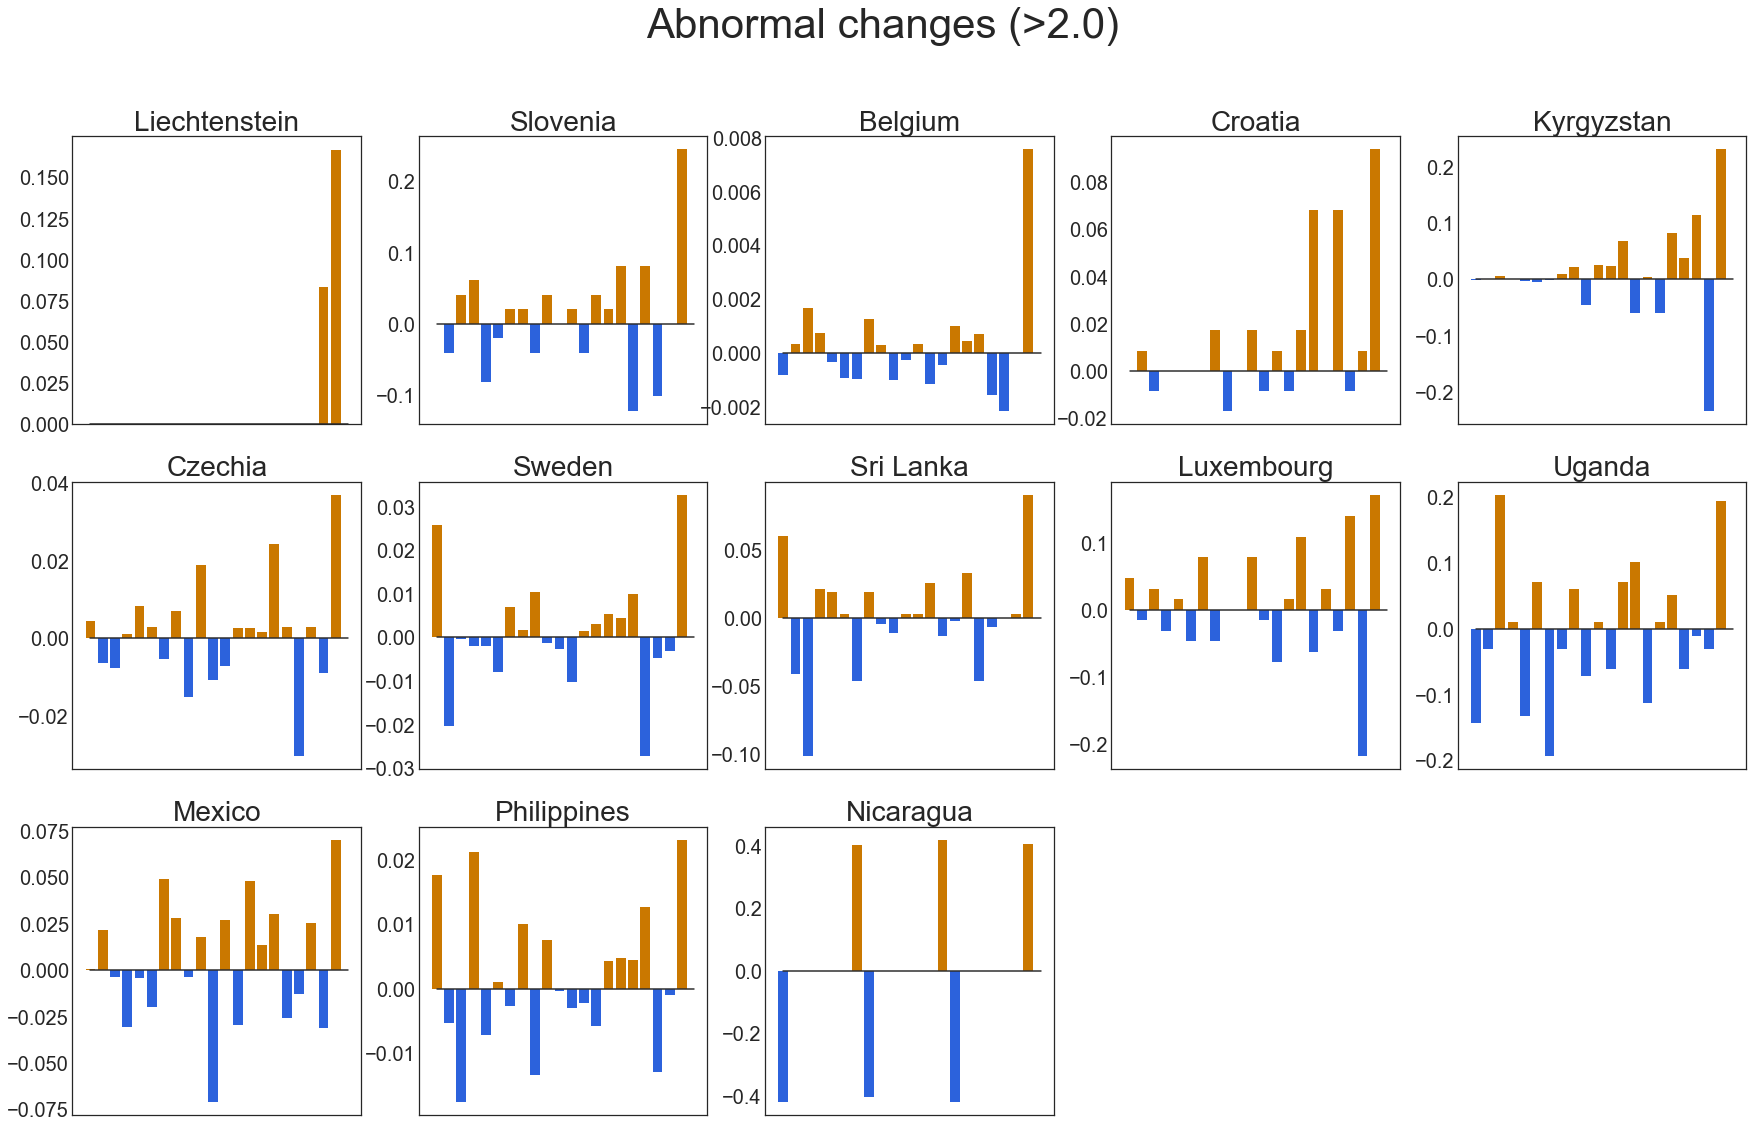

In [16]:
nrow = np.ceil(ab_num/5)
fig = plt.figure(figsize=(30,6*nrow))
for i in range(ab_num):
    ax = fig.add_subplot(nrow,5,i+1)
    temp = ratio_ts.iloc[i,2:].copy()
    temp.index = range(temp.shape[0])
    bar_1 = temp[temp>=0]
    bar_2 = temp[temp<0]
    ax.bar(bar_1.index,bar_1,color=colorlist[0])
    ax.bar(bar_2.index,bar_2,color=colorlist[2])
    ax.plot([0,temp.shape[0]],[0,0],color=colorlist[1])
    ax.set_xticks([])
    ax.tick_params(labelsize=20)
    ax.set_title(ratio_ts.index[i],fontsize=28)
fig.suptitle("Abnormal changes (>2.0)",fontsize=42)
plt.show()

# 5  Special Provinces/States

####  Beijing, China

In [32]:
def get_data_bj(dcate):
    df = pd.DataFrame()
    for i in range(3):
        filename = get_filename(dcate[i])
        temp = pd.read_csv(filename,header=0,index_col=None)
        cond1 = temp["Country/Region"] == "China"
        cond2 = temp["Province/State"] == "Beijing"
        df[dcate[i]] = temp[cond1 & cond2].iloc[0,4:]
    df["new_c"] = df["confirmed"].diff().fillna(0)
    df["new_d"] = df["deaths"].diff().fillna(0)
    df["new_r"] = df["recovered"].diff().fillna(0)
    df["ratio_d/c"] = df.iloc[:,1]/df.iloc[:,0]
    df["ratio_r/c"] = df.iloc[:,2]/df.iloc[:,0]
    df["ratio_a/c"] = 1-df["ratio_d/c"]-df["ratio_r/c"]
    df.iloc[:,6:9] = df.iloc[:,6:9].fillna(0)
        
    return df

df = get_data_bj(dcate)

In [38]:
present = present_data(df,"Beijing, China")
print("Province:","Beijing, China")
for i in range(present.shape[0]):
    if i < 7:
        print("%-20s%8.0f" % (present.index[i],present.iloc[i,0]),sep="")
    else:
        print("%-20s%7.2f%%" % (present.index[i],present.iloc[i,0]*100),sep="")

Province: Beijing, China
Total Active             257
Total Confirmed          850
Total Deaths               9
Total Recovered          584
New Confirmed              7
New Deaths                 0
New Recovered              0
Deaths/Confirmed       1.06%
Recovered/Confirmed   68.71%
Active/Confirmed      30.24%


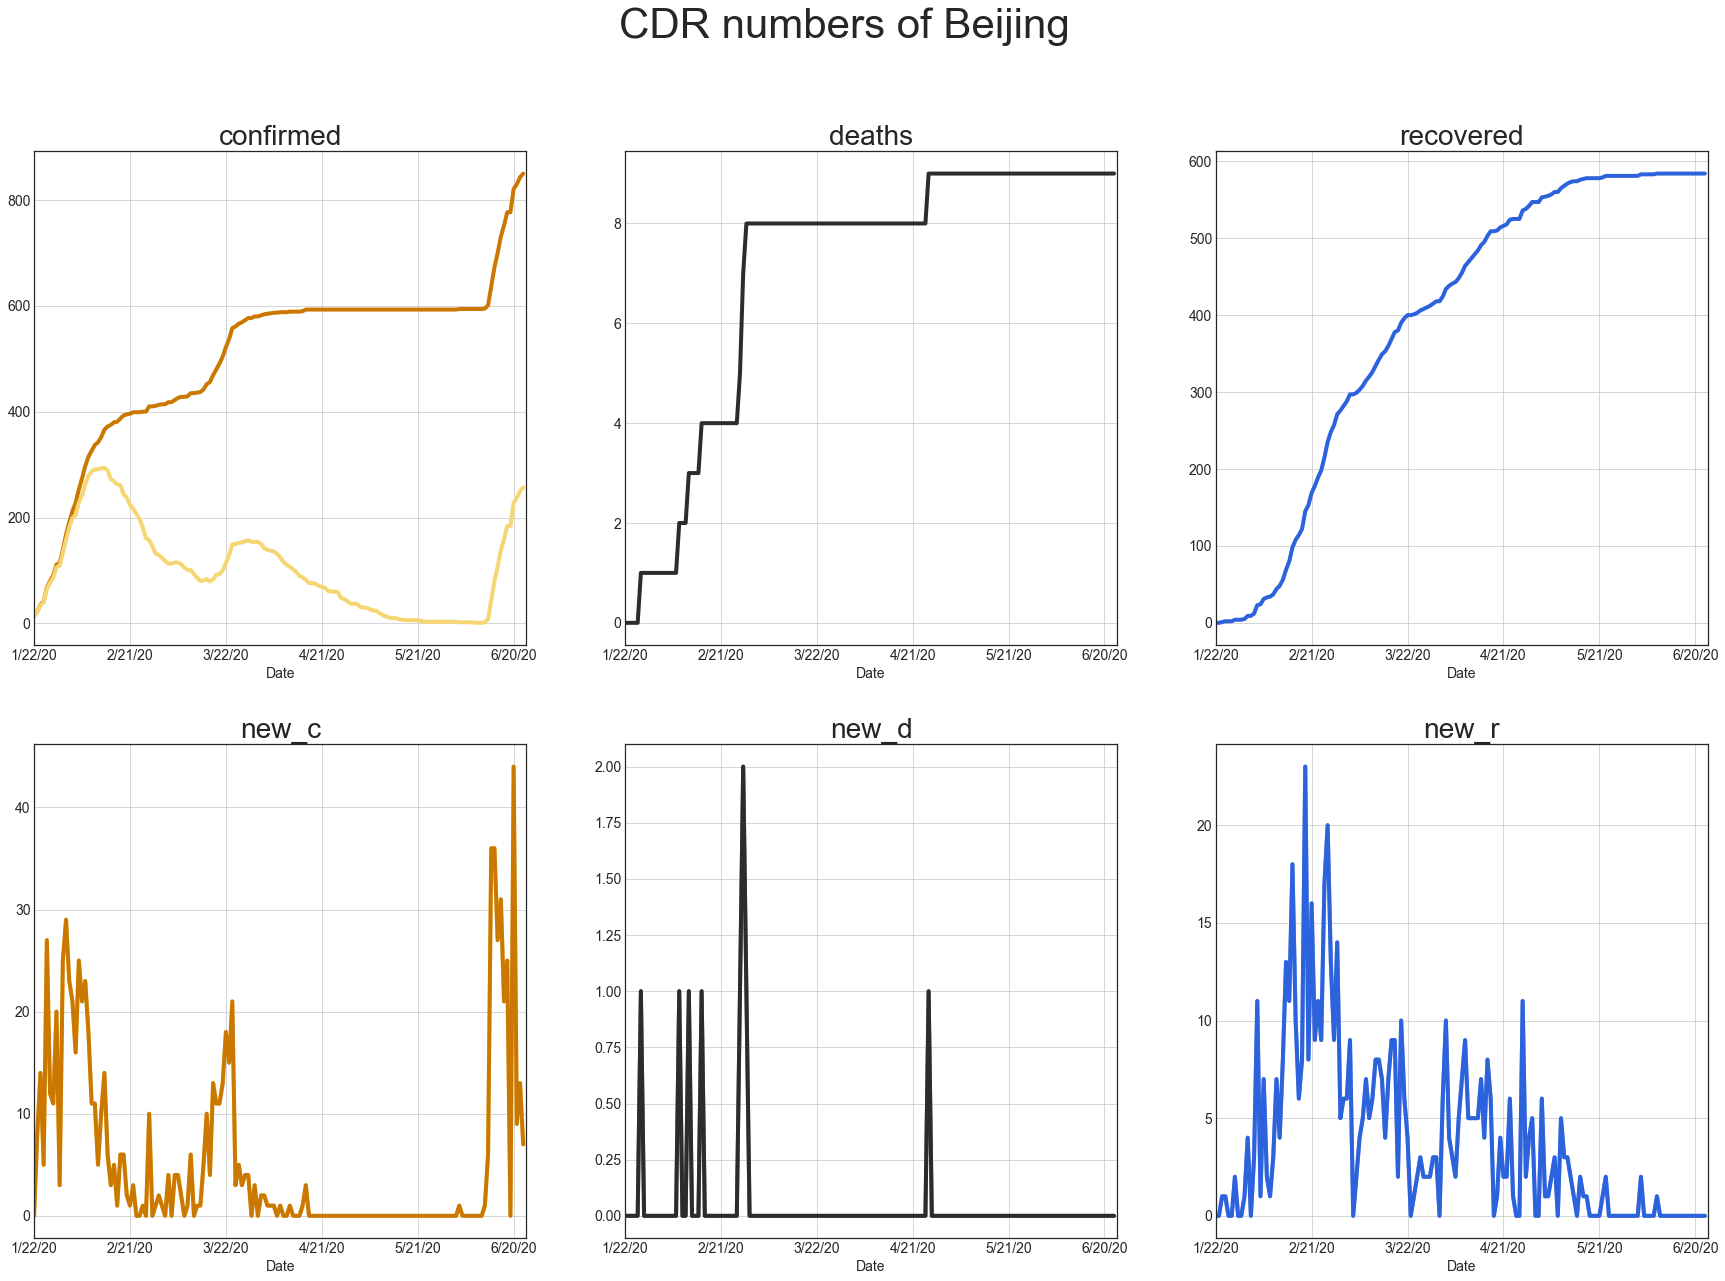

In [39]:
plot_num(df,"Beijing")

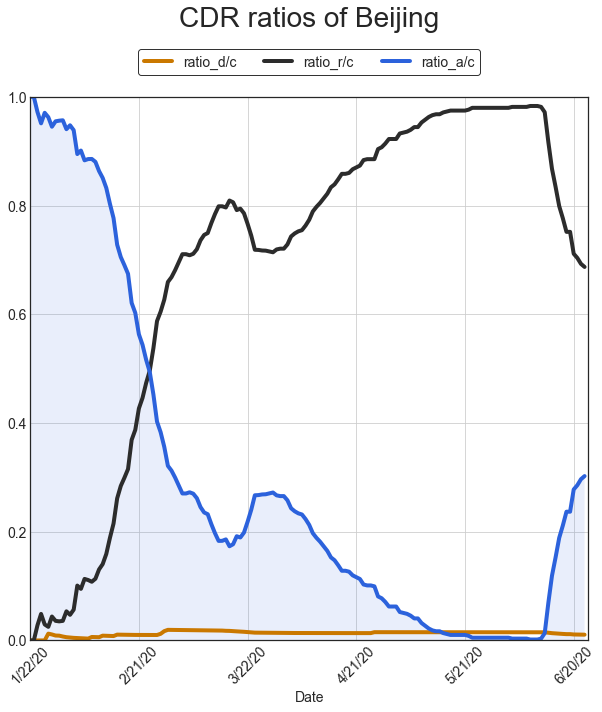

In [40]:
plot_rate(df,"Beijing")